In [1]:
import numpy as np
np.seterr(invalid='ignore')
import matplotlib.pyplot as plt
from tqdm import tqdm
import sympy
from sympy import *
print("Using sympy version", sympy.__version__)
from sympy.vector import CoordSys3D
R = CoordSys3D('R')
_x, _y, _z = symbols('x y z')

Using sympy version 1.3


In [2]:
_args = IndexedBase('args')

In [3]:
%matplotlib inline

In [97]:
class Doppler(object):
    
    def __init__(self, field, func):
        self.field = field
        self.func = func
    
    @property
    def field(self):
        return self._field
    
    @field.setter
    def field(self, new_field):
        """
        Differentiate the field to get the vector field
        defining the equipotential lines.
        
        """
        # Update the field
        self._field = new_field
        
        # Compute its derivatives
        f = self._field(R.x, R.y, R.z, _args)
        g = diff(f, R.x) * R.i + diff(f, R.y) * R.j + diff(f, R.z) * R.k
        h = -g.cross(R.x * R.i + R.y * R.j + R.z * R.k)
        h /= sqrt(h.dot(R.i) ** 2 + h.dot(R.j) ** 2)
        hx = h.dot(R.i)
        hy = h.dot(R.j)
        dxdt = hx.subs({R.x: _x, R.y: _y, R.z: _z})
        dydt = hy.subs({R.x: _x, R.y: _y, R.z: _z})
        self._dxdt = lambdify((_x, _y, _z, _args), dxdt, "numpy")
        self._dydt = lambdify((_x, _y, _z, _args), dydt, "numpy")
        
    def _dpdt_equip(self, p, args):
        """
        Return the derivative of the vector `p = (x, y, g)`
        with respect to the integration parameter `t`
        along an equipotential line.
        
        """
        x, y, g = p
        r2 = min(1.0, x ** 2 + y ** 2)
        z = np.sqrt(1 - r2)        
        dxdt = self._dxdt(x, y, z, args)
        dydt = self._dydt(x, y, z, args)
        dgdt = self.func(x, y, z) * np.sqrt(dxdt ** 2 + dydt ** 2)
        return np.array([dxdt, dydt, dgdt])
    
    def _rk4(self, x0, args, dt=1e-3, maxpts=10000, tol=1e-5):
        """
        
        """
        p = np.empty((maxpts, 3)) * np.nan
        p[0] = [x0, -np.sqrt(1 - x0 ** 2), 0.0]
        tau = self.field(x0, -np.sqrt(1 - x0 ** 2), 0, args)
        n = 0
        while True:
            if n >= maxpts - 1:
                raise ValueError("Maximum number of RK4 steps exceeded.")
            k1 = dt * self._dpdt_equip(p[n], args)
            k2 = dt * self._dpdt_equip(p[n] + 0.5 * k1, args)
            k3 = dt * self._dpdt_equip(p[n] + 0.5 * k2, args)
            k4 = dt * self._dpdt_equip(p[n] + k3, args)
            new_p = p[n] + (1. / 6.) * (k1 + 2 * k2 + 2 * k3 + k4)
            if (new_p[0] ** 2 + new_p[1] ** 2 > 1) or np.any(np.isnan(new_p)):
                if ((1 - p[n, 0] ** 2 - p[n, 1] ** 2) < tol):
                    break
                # Divide and conquer!
                dt /= 2
            else:
                p[n + 1] = new_p
                n += 1

        x = p[:n + 1, 0]
        y = p[:n + 1, 1]
        g = p[n, 2]
        return tau, g, x, y

In [226]:
def func(x, y, z):
    """
    Some function whose line integral we wish to take.
    In practice, this will be a spherical harmonic.
    
    """
    return 3 * x ** 2 + y ** 2 * z + x * y + 3 * y + x * z


def field(x, y, z, args):
    """
    The Doppler field, whose equipotential lines
    will be the curves along which we integrate
    `func`.
    
    """
    w = args[0]
    sini = args[1]
    cosi = args[2]
    alpha = args[3]
    cb = args[4]
    return w * sini * x * (1 - alpha * (sini * y + cosi * z) ** 2) + z * cb

# Instantiate our Doppler object
D = Doppler(field, func)

0.002598076211353316
0.0034641016151377548
0.004330127018922193


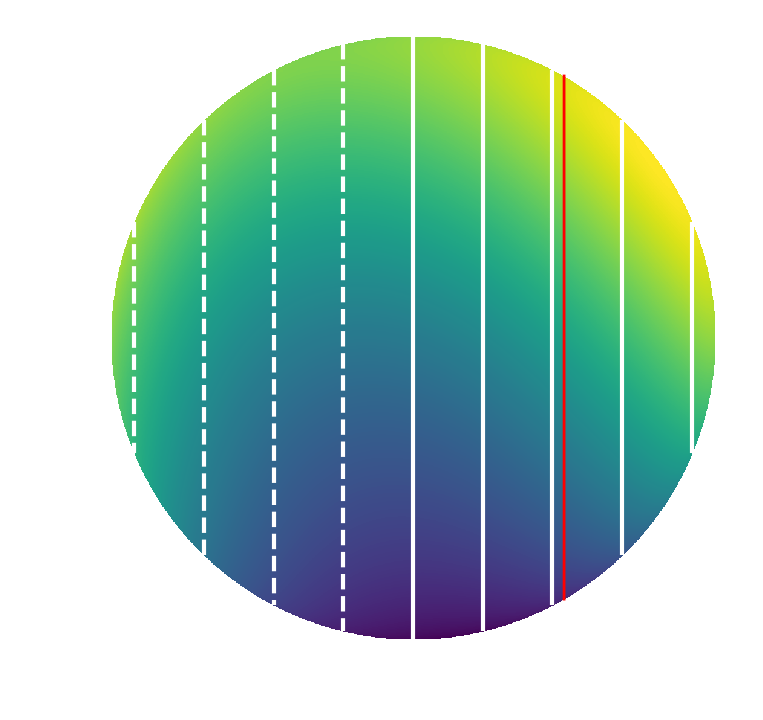

In [393]:
# Field parameters
w = 0.01
i = 60 * np.pi / 180
alpha = 0.0
cb = 0.0
args = [w, np.sin(i), np.cos(i), alpha, cb]

# Plot the image
x = np.linspace(-1, 1, 1000)
y = np.linspace(-1, 1, 1000)
x, y = np.meshgrid(x, y)
z = np.sqrt(1 - x ** 2 - y ** 2)
fig, ax = plt.subplots(1)
ax.imshow(D.func(x, y, z), origin="lower", extent=(-1, 1, -1, 1))
ax.contour(D.field(x, y, z, args), origin="lower", colors="w", extent=(-1, 1, -1, 1), levels=10);
ax.axis('off');

# Compute the line integral using RK4
for x0 in [0.3, 0.4, 0.5]:
    tau, g, x, y = D._rk4(x0, args, dt=1e-3)
    ax.plot(x, y, lw=1, color="r");
    print(tau)

In [389]:
# RK4
npts = 100
tau_rk4 = np.zeros(npts)
g_rk4 = np.zeros(npts)
g_rk4_ = np.zeros(npts)
for i, x in tqdm(enumerate(np.linspace(-1, 1, npts)), total=npts):
    try:
        tau_rk4[i], g_rk4[i], _, _ = D._rk4(x, args, dt=1e-3, maxpts=10000)
    except ValueError:
        tau_rk4[i], g_rk4[i] = np.nan, np.nan




  0%|          | 0/100 [00:00<?, ?it/s]


  3%|▎         | 3/100 [00:00<00:04, 21.31it/s]


  5%|▌         | 5/100 [00:00<00:05, 17.65it/s]


  7%|▋         | 7/100 [00:00<00:06, 14.54it/s]


  8%|▊         | 8/100 [00:00<00:07, 11.54it/s]


  9%|▉         | 9/100 [00:00<00:09,  9.28it/s]


 10%|█         | 10/100 [00:00<00:11,  8.07it/s]


 11%|█         | 11/100 [00:01<00:12,  7.37it/s]


 12%|█▏        | 12/100 [00:01<00:11,  7.36it/s]


 13%|█▎        | 13/100 [00:01<00:11,  7.28it/s]


 14%|█▍        | 14/100 [00:01<00:12,  7.16it/s]


 15%|█▌        | 15/100 [00:01<00:12,  6.91it/s]


 16%|█▌        | 16/100 [00:01<00:13,  6.34it/s]


 17%|█▋        | 17/100 [00:02<00:13,  5.93it/s]


 18%|█▊        | 18/100 [00:02<00:14,  5.85it/s]


 19%|█▉        | 19/100 [00:02<00:13,  5.91it/s]


 20%|██        | 20/100 [00:02<00:13,  5.88it/s]


 21%|██        | 21/100 [00:02<00:13,  5.77it/s]


 22%|██▏       | 22/100 [00:02<00:14,  5.51it/s]


 23%|██▎       | 23/100 [00:03<00:14,  5.3

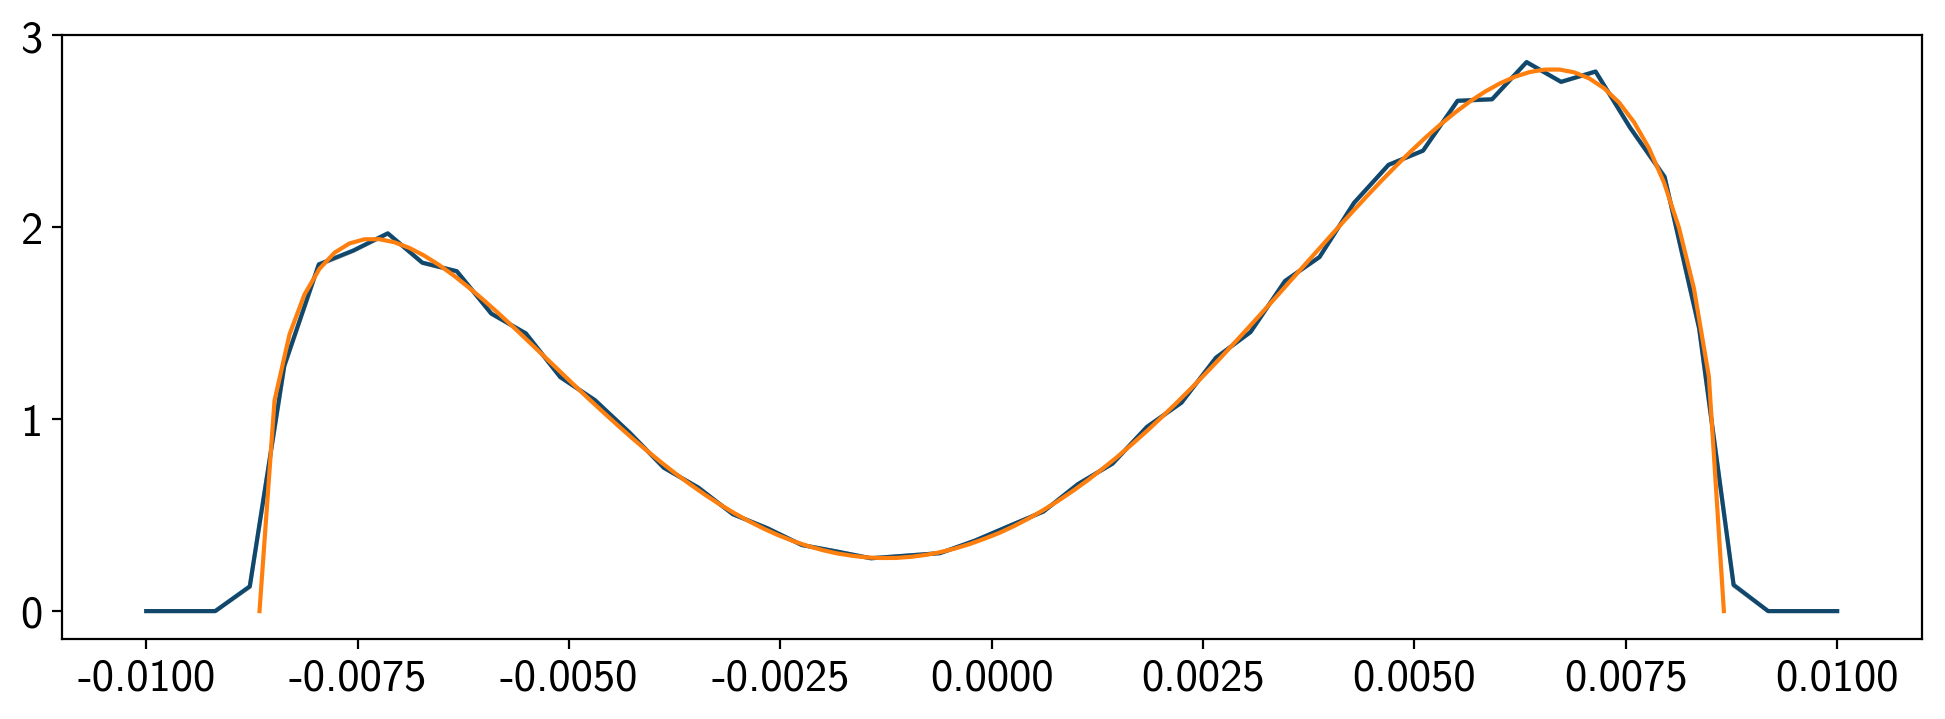

In [423]:
# Histogram
x = np.linspace(-1, 1, 1000)[1:-1]
y = np.linspace(-1, 1, 1000)[1:-1]
y, x = np.meshgrid(y, x)
inside = x ** 2 + y ** 2 < 1
x = x[inside].flatten()
y = y[inside].flatten()
z = np.sqrt(1 - x ** 2 - y ** 2)
npts = len(x)
tau_h = np.linspace(-0.01, 0.01, 50)
ntau = len(tau_h)
dtau = tau_h[1] - tau_h[0]
bins = np.append(tau_h - 0.5 * dtau, [tau_h[-1] + 0.5 * dtau])
_dDdx = diff(field(_x, _y, sqrt(1 - _x ** 2 - _y ** 2), _args), _x)
dDdx = lambdify((_x, _y, _args), _dDdx, "numpy")
_dDdy = diff(field(_x, _y, sqrt(1 - _x ** 2 - _y ** 2), _args), _y)
dDdy = lambdify((_x, _y, _args), _dDdy, "numpy")
jac = np.sqrt(dDdx(x, y, args) ** 2 + dDdy(x, y, args) ** 2)
dA = (y[1] - y[0])  ** 2
g_h, _ = np.histogram(D.field(x, y, z, args), weights=D.func(x, y, z) * jac * dA / dtau, bins=bins)

# W/ circle integration
eps = 0.5 * (y[1] - y[0])
dA = np.array([pixel_area(xi - eps, xi + eps, yi - eps, yi + eps) for xi, yi in zip(x, y)])
g_h2, _ = np.histogram(D.field(x, y, z, args), weights=D.func(x, y, z) * jac * dA / dtau, bins=bins)

plt.plot(tau_h, g_h);
plt.plot(tau_h, g_h2, color="k", alpha=0.4);
plt.plot(tau_rk4, g_rk4);